6/29/2024\
Author: Michael Stoll\
\
In this assignment, I am going to be using the basic wine quality dataset that we've been working with since the beginning of the class. The objective here is to find both the best regression model, as well as the best hyperparameters for that regression model, to predict the quality of a given bottle of red wine.\
First I need to do a bit of setup, starting with importing the dataset.

In [8]:
import numpy as np
import pandas as pd
from numpy import float32
data = pd.read_csv("winequality-red.csv", sep=',')
data


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Now that we know it's properly imported, I'm going to display a correlation heatmap, just as a refresher of how well the different features correlate to one another.

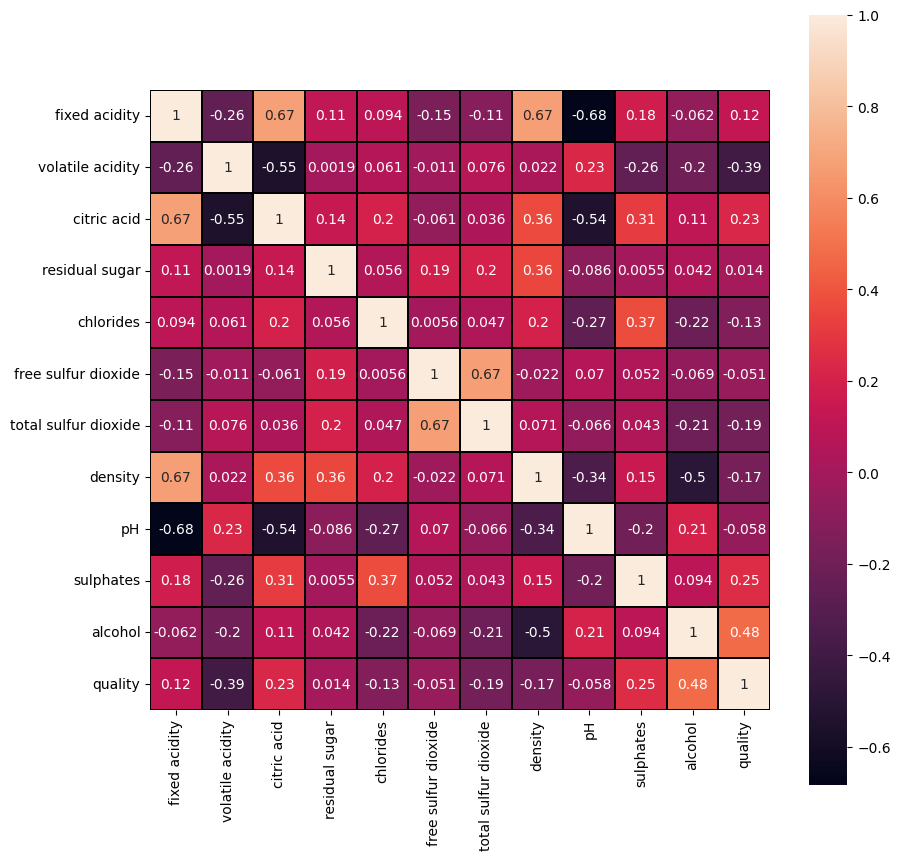

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square = True, annot=True, annot_kws={'fontsize':10}, linewidths=.1, vmax=1, linecolor='black')
plt.show()

It's clear from this simple heatmap that there won't be a perfect accuracy, but that's not the point. All that I'm trying to do is get as close as possible.\
Now it's time to split off the training data from the testing data.

In [9]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=['quality'])
target = data['quality']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state= 721)


Just for the sake of clean and maintained code, I decided to make a couple of functions to abstract some of the details away from the main search.\
\
Build started as a calculator for several different attributes, but now it just fits a given model to the given training data and returns either the optimized model or the values that it predicted. Notably, it takes a boolean parameter as well, since I want to be able to use the same function for both the unoptimized and the optimized algorithms and intend to use those two in slightly different ways by returning the predicted data to the unoptimized usages and the fitted model to the optimized usages.\
\
Plot is exactly what it sounds like. It simply generates a scatterplot that contrasts the predicted data against the actual data, and I was using this for visual reference for myself to visually understand what was happening with the data. In a perfect world, these points would fall along a line with a slope of 1. But this is no perfect world.

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def build(model, opt):
    model.fit(features_train, target_train)
    pred = model.predict(features_test)
    if(not opt):
        return pred
    else:
        return model

def plot(model,pred):
    plt.scatter(pred, target_test, color='blue')
    plt.title(str(model))
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.grid(True)
    plt.show()

Now it's time to build search spaces so that there is something to optimize. Given that the random search and the Bayesian search use the same parameters, I'm going to build the same search spaces for both.\
\
This also happens to be, of course, where I have to make the determination for which regressions I'm going to use. For now, I've selected the random forest regressor, the support vector regressor, the decision tree regressor, and the gradient boosting regressor. I'm loading the functions themselves into one list, and the search spaces into another, for reasons that will become clear in the next step.\
\
For each of these regressors, I found a list of parameters that I felt was thorough but not so intense as to be noncomputable. For example, I could give the random forest regressor a list of estimators that ranges from 100,100000 just to see what would happen, but given that I'm already taking 900 * 3 * 18 * 5 = 243,000 potential computations (not including the number of iterations or cross validations that are upcoming), I thought that range(100,1000) would probably do the trick. I've well exceeded the reasonable capacities of grid search, in my humble opinion.

In [2]:
#build search spaces
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from time import time #I want to know how long they take
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from tabulate import tabulate


estimators = list(range(100,1000))
maxFeatures = ['sqrt', 'log2', None]
minSplit = list(range(2,20))
minLeaf = list(range(1,5))
randomGrid = {'n_estimators':estimators, 'max_features':maxFeatures, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

maxIter = list(range(100,1000))
gamma = ['scale', 'auto']
degree = list(range(3,16))
svcGrid = {'max_iter':maxIter, 'gamma':gamma, 'degree':degree}

splitter = ['best', 'random']
maxDepth = list(range(3,115))
dtGrid = {'splitter':splitter, 'max_depth':maxDepth, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

gbGrid = {'max_depth':maxDepth, 'max_features':maxFeatures, 'min_samples_leaf':minLeaf, 'min_samples_split':minSplit}

space = [svcGrid, dtGrid, gbGrid, randomGrid]
models = [SVR(), DecisionTreeRegressor(), GradientBoostingRegressor(),RandomForestRegressor()]



Just for illustrative effect, I'm going to make a table to show how the different regressors use these hyperparameters. The names of the attributes are on the leftmost column, the ranges of those attributes are in the column next to it, the names of the regressors are on the top, and the numbers (that aren't in the bottom row) represent the factor by which each parameter expands the search space. That bottom row, as labeled, indicates the total number of combinations that are in the search space for each model. Obviously random forest has the most parameters, but all four of the models I'm using have plenty enough combinations (especially when combined with the number of iterations and cross validations that will be in the next step) to overwhelm a traditional grid search.

In [4]:
searchSpaces = [['Attribute Name', 'Attribute Range'] + models, 
                ['n_estimators', '(100-1000)', '', '', '', '900'],
                ['splitter', '(Best, Random)', '', '2', '', ''],
                ['max_depth', '(3-115)', '', '112', '112', ''],
                ['min_samples_split', '(2-20)', '', '18', '18', '18'],
                ['min_samples_leaf', '(1-5)','', '5', '5', '5'],
                ['max_features', '(sqrt, log2, None)','', '', '3', '3'],
                ['gamma', '(Scale, Auto)', '2', '', '', ''],
                ['max_iter', '(100-1000)', '900', '', '', ''],
                ['degree', '(3-16)', '13', '', '', ''],
                ['', 'Total Combos:', 2*13*900, 2*112*18*5, 112*18*5*3, 900*18*5*3]]
print(tabulate(searchSpaces, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════╤════════════════════╤═════════╤═══════════════════════════╤═══════════════════════════════╤═══════════════════════════╕
│ Attribute Name    │ Attribute Range    │ SVR()   │ DecisionTreeRegressor()   │ GradientBoostingRegressor()   │ RandomForestRegressor()   │
╞═══════════════════╪════════════════════╪═════════╪═══════════════════════════╪═══════════════════════════════╪═══════════════════════════╡
│ n_estimators      │ (100-1000)         │         │                           │                               │ 900                       │
├───────────────────┼────────────────────┼─────────┼───────────────────────────┼───────────────────────────────┼───────────────────────────┤
│ splitter          │ (Best, Random)     │         │ 2                         │                               │                           │
├───────────────────┼────────────────────┼─────────┼───────────────────────────┼───────────────────────────────┼───────────────────────────┤
│ max_depth  

With the initialization taken care of, it's finally time to begin the searching.\
\
The first thing I want to point out is the RandomizedSearchCV function's parameters. "model" and "space" should be pretty self explanatory, even though there is some strange syntax going on with subscripting "space" (this is just to ensure that the model and space lists iterate at the same rate so that the correct search space is used for each regressor). "n_iter" and "scoring" ought to be straightforward as well, but there could understandably be some confusion regarding "n_jobs" and "cv".\
n_jobs is just the amount of processors that the environment will utilize from your machine. Since I've set it to -1, it will use all of the processing power my machine has to offer. God knows it will need it.\
"cv" is potentially the most interesting of the parameters. CV, you might guess, stands for cross validation, and by providing the value "4" I'm requesting that for every iteration, the search function cross validates 4 times.\
\
Next, I'd like to address what might be an apparent lack of nested resampling in this (and the next) search function. There isn't a formal for loop visible (besides the one that switches the model used), but rest assured that nested resampling is still occurring because that loop is being abstracted by the cross_val_score function. The whole point of that function is to take the results of the search and cross validate them with the provided dataset, which gives us a nested layer of cross validation.\
\
The final thing that I want to talk about is a higher-level, broad description of the function. It's a bit messy, of course, but I'm at the stage in reworking it where I'm afraid to touch anything, lest I make it not work again. So instead, a (not so) brief overview:\
After initializing a clock and a number of placeholders (to be filled by the best model and its details), the cell begins a cross-validated loop that iterates 4 times to find the best combination of hyperparameters (scoring based on the resultant r-squared score) on this permutation of the data. Then that result is cross-validated against another loop that runs 3 times, to observe the resultant r-squared score from each further permutation of the data. The .mean() function on the end serves to take the simple mean of these r-squared scores. After the clock is stopped and i is incremented (to keep the correct model with the correct search space) that mean r-squared score is compared with the last saved r-squared score. If it is greater, the previous model and its attributes are replaced with the current model and its attributes. Along the way, the time and mean r-squared score for each process is printed, and at the end the best performing model and its attributes are also printed.

In [6]:
#randomized search
from time import time #I want to know how long they take
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

randScore = 0
randName = ""
bestRandParams = ""
randTime = 0
i = 0
for model in models:
    currentTime = time()

    #"inner loop" occurs here
    search = RandomizedSearchCV(model, space[i], n_iter=500, scoring='r2', n_jobs=-1, cv=4)
    #"outer loop" occurs here
    mean = cross_val_score(search, features, target, scoring='r2', cv = 3).mean()

    print("average r2 score: " + str(mean))
    i = i + 1
    totalTime = time() - currentTime
    print(str(model) + " took " + str(totalTime) + " seconds.\n")
    if(mean > randScore):
        randScore = mean
        randName = model
        bestRandParams = build(search,True).best_params_
        randTime = totalTime
        

print("\nThe best performing model was " + str(randName) + " with the parameters " + str(bestRandParams) + " and an average r-squared score of " + str(randScore))

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=243).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=244).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=380).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


average r2 score: 0.02461838118903566
SVR() took 23.345443725585938 seconds.



C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=998).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


average r2 score: 0.15682685544508493
DecisionTreeRegressor() took 2.6068341732025146 seconds.

average r2 score: 0.32908208732209343
GradientBoostingRegressor() took 47.275972843170166 seconds.

average r2 score: 0.34769538153837704
RandomForestRegressor() took 693.0897057056427 seconds.


The best performing model was RandomForestRegressor() with the parameters {'n_estimators': 818, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'} and an average r-squared score of 0.34769538153837704


In this instance, the random forest regressor happened to have the highest r-squared score. This indicates that it is the best performing of the regressors, since a higher r-squared score correlates to a higher accuracy. It should follow logically that there was some substantial r-squared improvement to get to these parameters from the default. It just so happens that we can display them side by side and see for ourselves.

r2 for default: 0.5138697700823163
r2 for optimized: 0.529021460900231


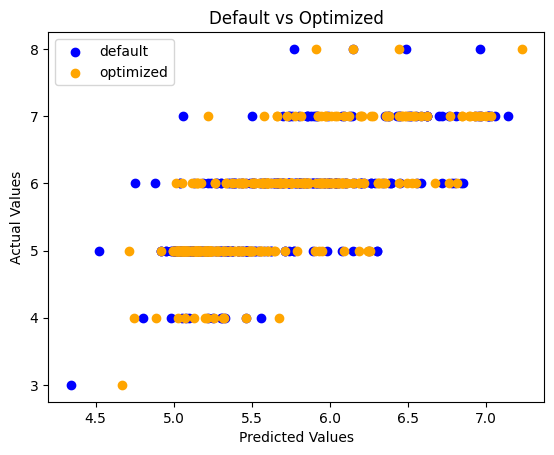

In [7]:
dPred = RandomForestRegressor().fit(features_train, target_train).predict(features_test)
oPred = RandomForestRegressor(n_estimators=bestRandParams["n_estimators"], min_samples_split=bestRandParams["min_samples_split"], min_samples_leaf=bestRandParams["min_samples_leaf"], max_features=bestRandParams["max_features"]).fit(features_train, target_train).predict(features_test)

print("r2 for default: " + str(r2_score(target_test, dPred)))
print("r2 for optimized: " + str(r2_score(target_test, oPred)))

plt.scatter(dPred, target_test, color='blue', label="default")
plt.scatter(oPred, target_test, color='orange', label="optimized")
plt.legend(loc="upper left")
plt.title("Default vs Optimized")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Obviously there will be some variation in the exact scores, but there is a clear trend that the optimized version does, in fact, have a higher score.\
Notably, several of the other regressors have less than stellar performance. For example, several times I've run SVR and ended up with a negative r-squared score. No one ever said that this was going to be the be all end all of searches. That's where Bayesian searching comes in, actually.\
\
The Bayesian search is a much more thorough process. As such, it takes much more time to run, but the result is also more accurate. It's sort of like taking the time to sight in a scope on a rifle and use a rangefinder to find the correct distance and calibrate a shot, versus just beginning to fire wildly towards the target and hope that you eventually find a bullseye. Sometimes it happens, but Bayesian optimization guarantees that that happens. So long as you have enough iterations, that is.\
\
The setup is almost identical to the random search setup, with the only real deviations being the number of iterations (see also: time complexity) and the names of the variables.

In [12]:
#bayesian opt
from skopt import BayesSearchCV

bayesScore = 0
bayesName = ""
bestBayesParams = ""
bayesTime = 0
i = 0
for model in models:
    currentTime = time()
    #"inner loop" occurs here
    #random forest takes so much longer than the others that I'm giving it its own line with a smaller amount of iterations
    if i==3:
        search = BayesSearchCV(model, space[i], n_iter=100, scoring='r2', n_jobs=-1, cv=5)
    else:
        search = BayesSearchCV(model, space[i], n_iter=200, scoring='r2', n_jobs=-1, cv=5)
    #"outer loop" occurs here
    mean = cross_val_score(search, features, target, cv = 3).mean()
    print("average r2 score: " + str(mean))

    i = i + 1
    totalTime = time() - currentTime
    print("process took " + str(totalTime) + " seconds.\n")
    if(mean > bayesScore):
        bayesScore = mean
        bayesName = model
        bestBayesParams = build(search,True).best_params_
        bayesTime = totalTime
        

print("\nThe best performing model was " + str(bayesName) + " with the parameters " + str(bestBayesParams) + " and a mean accuracy of " + str(bayesScore))

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=276).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=392).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=911).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


average r2 score: 0.08170933519314576
process took 787.8521728515625 seconds.



C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=820).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


average r2 score: 0.17254875677704604
process took 131.47501850128174 seconds.

average r2 score: 0.32213864807822123
process took 426.7791335582733 seconds.

average r2 score: 0.35294843677612137
process took 4535.735728979111 seconds.


The best performing model was RandomForestRegressor() with the parameters OrderedDict({'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 839}) and a mean accuracy of 0.35294843677612137


Once again, RandomForestRegressor appears to be both the longest runtime and the highest r-squared score. Just to verify, I'll go ahead and display these again:

r2 for default: 0.5178550099347148
r2 for optimized: 0.5307779362708518


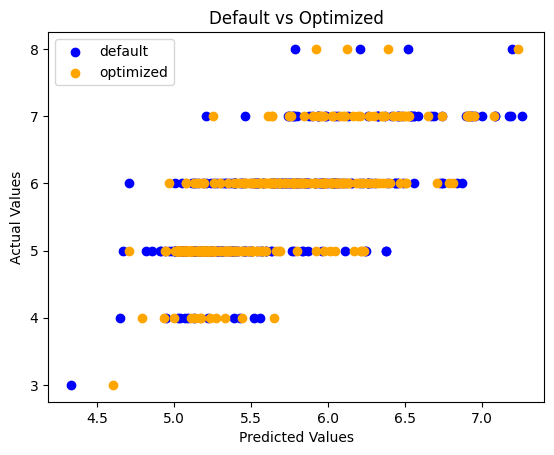

In [15]:
dPred = RandomForestRegressor().fit(features_train, target_train).predict(features_test)
oPred = RandomForestRegressor(n_estimators=bestBayesParams["n_estimators"], min_samples_split=bestBayesParams["min_samples_split"], min_samples_leaf=bestBayesParams["min_samples_leaf"], max_features=bestBayesParams["max_features"]).fit(features_train, target_train).predict(features_test)

print("r2 for default: " + str(r2_score(target_test, dPred)))
print("r2 for optimized: " + str(r2_score(target_test, oPred)))

plt.scatter(dPred, target_test, color='blue', label="default")
plt.scatter(oPred, target_test, color='orange', label="optimized")
plt.legend(loc="upper left")
plt.title("Default vs Optimized")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

Again, clearly, the optimization has resulted in a better-fit model than the default parameters. I'm going to put the results of these two searches, plus the default case, into a table to compare:

In [16]:
#for the sake of gathering data I actually need to run this one and cross validate it so I have accurate numbers to work with
start = time()
word = RandomForestRegressor().fit(features_train, target_train)
defaultMean = cross_val_score(word, features, target, cv = 15).mean()
defaultTime = time() - start

default = {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0}
results = [['Param Name', 'Default', 'Random', 'Bayesian'], 
           ['Max Features', default['max_features'], bestRandParams['max_features'], bestBayesParams['max_features']], 
           ['Min Leaf', default['min_samples_leaf'], bestRandParams['min_samples_leaf'], bestBayesParams['min_samples_leaf']], 
           ['Min Split', default['min_samples_split'], bestRandParams['min_samples_split'], bestBayesParams['min_samples_split']], 
           ['Estimator Number', default['n_estimators'], bestRandParams['n_estimators'], bestBayesParams['n_estimators']],
           ['r2 score', defaultMean, randScore, bayesScore],
           ['Runtime', defaultTime, randTime, bayesTime]]
print(tabulate(results, headers='firstrow', tablefmt='fancy_grid'))

╒══════════════════╤════════════╤═════════════════════╤═════════════════════╕
│ Param Name       │    Default │ Random              │ Bayesian            │
╞══════════════════╪════════════╪═════════════════════╪═════════════════════╡
│ Max Features     │   1        │ log2                │ sqrt                │
├──────────────────┼────────────┼─────────────────────┼─────────────────────┤
│ Min Leaf         │   1        │ 1                   │ 1                   │
├──────────────────┼────────────┼─────────────────────┼─────────────────────┤
│ Min Split        │   2        │ 2                   │ 3                   │
├──────────────────┼────────────┼─────────────────────┼─────────────────────┤
│ Estimator Number │ 100        │ 818                 │ 839                 │
├──────────────────┼────────────┼─────────────────────┼─────────────────────┤
│ r2 score         │   0.270347 │ 0.34769538153837704 │ 0.35294843677612137 │
├──────────────────┼────────────┼─────────────────────┼─────────

The results for the parameters show clear trends in some directions, such as the number of estimators increasing and the number of leaf nodes staying stagnant.\
The bottom two rows are far more telling. As you move from Default to Bayesian, the r-squared score increases quite significantly. So too does the runtime, at least on my machine. The question of which one is best is a bit complicated here, since it really becomes an argument of time complexity versus accuracy. The Bayesian optimized score is clearly the highest, but is it really worth running over 6 times longer than the random optimization? For the sake of this assignment, I will say yes, since the point was to find the best predictor, not the fastest. If I wanted the fastest I suppose I would have worked with the default parameters.